In [1]:
import pandas as pd
import numpy as np

## Load Data

In [65]:
#load data
us_train = pd.read_csv('/Users/guanlxy/Documents/github/ids-705-final-project/data/processed/us-train.csv')
us_val = pd.read_csv('/Users/guanlxy/Documents/github/ids-705-final-project/data/processed/us-val.csv')
us_test = pd.read_csv('/Users/guanlxy/Documents/github/ids-705-final-project/data/processed/us-test.csv')

london_test = pd.read_csv('/Users/guanlxy/Documents/github/ids-705-final-project/data/processed/london-test.csv')
madrid_test = pd.read_csv('/Users/guanlxy/Documents/github/ids-705-final-project/data/processed/madrid-test.csv')
paris_test = pd.read_csv('/Users/guanlxy/Documents/github/ids-705-final-project/data/processed/paris-test.csv')

In [66]:
y_us_train = us_train.log_price
y_us_val = us_val.log_price
y_us_test = us_test.log_price

y_london_test = london_test.log_price
y_madrid_test = madrid_test.log_price
y_paris_test = paris_test.log_price

In [67]:
X_us_train = us_train.drop(columns=['log_price'])
X_us_val = us_val.drop(columns=['log_price'])
X_us_test = us_test.drop(columns=['log_price'])

X_london_test = london_test.drop(columns=['log_price'])
X_madrid_test = madrid_test.drop(columns=['log_price'])
X_paris_test = paris_test.drop(columns=['log_price'])

In [68]:
# create full train set (val + existing train)
X = pd.concat([X_us_train, X_us_val]).reset_index(drop=True)
y = pd.concat([y_us_train, y_us_val]).reset_index(drop=True)

In [96]:
X_eur = pd.concat([X_london_test, X_paris_test, X_madrid_test]).reset_index(drop=True)
y_eur = pd.concat([y_london_test, y_paris_test, y_madrid_test]).reset_index(drop=True)

## Standardize data

In [69]:
X_mean = X.mean()
X_std = X.std()

In [70]:
X_us_train = (X_us_train - X_mean) / X_std
X_us_val = (X_us_val - X_mean) / X_std
X_us_test = (X_us_test - X_mean) / X_std
X = (X - X_mean) / X_std

X_london_test = (X_london_test - X_mean) / X_std
X_madrid_test = (X_madrid_test - X_mean) / X_std
X_paris_test = (X_paris_test - X_mean) / X_std

## PCA

array([0.05376836, 0.0962778 , 0.12795131, 0.15565539, 0.17992859,
       0.19953286, 0.21652475, 0.23129406, 0.24572301, 0.25941669,
       0.2721341 , 0.28467122, 0.29683117, 0.30856681, 0.32014572,
       0.33151027, 0.34246716, 0.3532077 , 0.36366473, 0.37402051,
       0.38428871, 0.39450053, 0.40448859, 0.41441442, 0.42425482,
       0.43408558, 0.4438756 , 0.45365036, 0.46338789, 0.47310453,
       0.48279428, 0.49246491, 0.50213012, 0.51178246, 0.52142757,
       0.53106756, 0.54070016, 0.55033057, 0.55995598, 0.56957884,
       0.57919864, 0.5888169 , 0.59843224, 0.60804676, 0.6176505 ,
       0.62723466, 0.63681077, 0.64636386, 0.65587696, 0.66535122,
       0.6747777 , 0.68409454, 0.69334832, 0.70257459, 0.7116386 ,
       0.72063956, 0.72946075, 0.73818836, 0.74682534, 0.75512868,
       0.76339738, 0.77161875, 0.77977441, 0.78787164, 0.79589059,
       0.80383948, 0.81171716, 0.81957809, 0.82738962, 0.83513008,
       0.84266671, 0.85004693, 0.85740155, 0.86460892, 0.87165

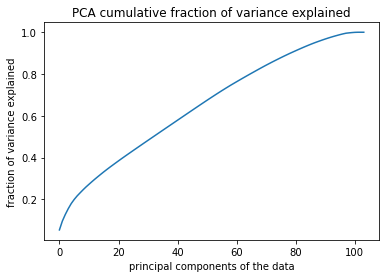

In [15]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier, NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


#figure out how much dimension we need after pca
pca = PCA(n_components=X.shape[1])
pca_transform = pca.fit_transform(X,y)
var_values = pca.explained_variance_ratio_


cum_exp_variance = np.cumsum(var_values)
plt.plot(cum_exp_variance)
plt.xlabel('principal components of the data')
plt.ylabel('fraction of variance explained')
plt.title('PCA cumulative fraction of variance explained')

cum_exp_variance

## KNN

In [17]:
# Reduce dimension to 2/5/15 with PCA
r_state = 2021
pca_2 = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=r_state))
pca_15 = make_pipeline(StandardScaler(), PCA(n_components=15, random_state=r_state))
pca_40 = make_pipeline(StandardScaler(), PCA(n_components=40, random_state=r_state))

In [18]:
# Make a list of the methods to be compared
dim_reduction_methods = [('PCA2', pca_2),('PCA15', pca_15),('PCA40', pca_40)]

In [19]:
from sklearn.metrics import mean_squared_error
import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

### Tune PCA

In [20]:
n_neighbors=5
knn = KNeighborsRegressor(n_neighbors=n_neighbors)

for i, (name, model) in enumerate(dim_reduction_methods):
    
    #start timer
    time0 = time.time()
    # Fit the method's model
    model.fit(X_us_train, y_us_train)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_us_train), y_us_train)
    #time for training
    time1 = time.time()
    
    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(X_us_val), y_us_val)
    y_knn = knn.predict(model.transform(X_us_val))
    
    #time for test
    time2 = time.time()
    
    rmse = mean_squared_error(np.exp(y_us_val), np.exp(y_knn), squared=False)
    mae = mean_absolute_error(np.exp(y_us_val), np.exp(y_knn))
    medae = median_absolute_error(np.exp(y_us_val), np.exp(y_knn))
    
    
    print("{}, KNN (k={})\nTest score = {:.2f}".format(name,n_neighbors,acc_knn))
    print('RMSE (on normal price):',rmse)
    print('Mean Absolute Error:', mae)
    print('Median Absolute Error:', medae)
    print('KNN ({}) training time = {}, prediction time ={}\n'.format(name,time1-time0,time2-time1))

PCA2, KNN (k=5)
Test score = 0.19
RMSE (on normal price): 149.21873700288302
Mean Absolute Error: 79.3323267712331
Median Absolute Error: 45.14935161962667
KNN (PCA2) training time = 0.44417881965637207, prediction time =0.14484095573425293

PCA15, KNN (k=5)
Test score = 0.54
RMSE (on normal price): 130.81557404431334
Mean Absolute Error: 62.70393269655483
Median Absolute Error: 30.417267982624615
KNN (PCA15) training time = 0.47139406204223633, prediction time =17.578701972961426

PCA40, KNN (k=5)
Test score = 0.53
RMSE (on normal price): 130.63816330966847
Mean Absolute Error: 62.83633631617739
Median Absolute Error: 30.59135462375212
KNN (PCA40) training time = 0.5809359550476074, prediction time =27.01469588279724



### Tune N_neighbors

In [23]:
for i in (2,3,5,7,9):
    knn = KNeighborsRegressor(n_neighbors=i)
    #start timer
    time0 = time.time()
   
    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(pca_15.transform(X_us_train), y_us_train)
    #time for training
    time1 = time.time()
    
    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(pca_15.transform(X_us_val), y_us_val)
    y_knn = knn.predict(pca_15.transform(X_us_val))
    
    #time for test
    time2 = time.time()
    
    rmse = mean_squared_error(np.exp(y_us_val), np.exp(y_knn), squared=False)
    mae = mean_absolute_error(np.exp(y_us_val), np.exp(y_knn))
    medae = median_absolute_error(np.exp(y_us_val), np.exp(y_knn))
    
    
    print("KNN(PCA_15) (k={})\nTest score = {:.2f}".format(i,acc_knn))
    print('RMSE (on normal price):',rmse)
    print('Mean Absolute Error:', mae)
    print('Median Absolute Error:', medae)
    print('KNN (PCA_15) training time = {}, prediction time ={}\n'.format(time1-time0,time2-time1))

KNN(pca_15) (k=2)
Test score = 0.44
RMSE (on normal price): 139.7628557501551
Mean Absolute Error: 69.55451067340087
Median Absolute Error: 33.85726574839079
KNN (PCA40) training time = 0.08926796913146973, prediction time =13.189510107040405

KNN(pca_15) (k=3)
Test score = 0.50
RMSE (on normal price): 133.82604971951554
Mean Absolute Error: 65.49015823224227
Median Absolute Error: 31.546097207204134
KNN (PCA40) training time = 0.11153769493103027, prediction time =15.247225284576416

KNN(pca_15) (k=5)
Test score = 0.54
RMSE (on normal price): 130.81557404431334
Mean Absolute Error: 62.70393269655483
Median Absolute Error: 30.417267982624615
KNN (PCA40) training time = 0.09190487861633301, prediction time =16.511346101760864

KNN(pca_15) (k=7)
Test score = 0.56
RMSE (on normal price): 129.6277843479507
Mean Absolute Error: 61.53467192528808
Median Absolute Error: 29.94332369502944
KNN (PCA40) training time = 0.09988188743591309, prediction time =18.318329095840454

KNN(pca_15) (k=9)
Te

### Train Ultimate model

In [64]:
from sklearn.metrics import r2_score

In [90]:
knn_ult = KNeighborsRegressor(n_neighbors=7)
#start timer
time0 = time.time()

# Fit a nearest neighbor classifier on the embedded training set
knn_ult.fit(pca_15.transform(X), y)
#time for training
time1 = time.time()

# Compute the nearest neighbor accuracy on the embedded test set
y_knn_ult = knn_ult.predict(pca_15.transform(X))
r2 = r2_score(y, y_knn_ult)


#time for test
time2 = time.time()

rmse_ult = mean_squared_error(np.exp(y), np.exp(y_knn_ult), squared=False)
mae_ult = mean_absolute_error(np.exp(y), np.exp(y_knn_ult))
medae_ult = median_absolute_error(np.exp(y), np.exp(y_knn_ult))

print('Result KNN for US training data')
print("KNN(PCA_15) (k=7)\n R^2 = {:.2f}".format(r2))
print('RMSE (on normal price):',rmse_ult)
print('Mean Absolute Error:', mae_ult)
print('Median Absolute Error:', medae_ult)
print('KNN (PCA_15) (k=7) training time = {:.2f}, prediction time ={:.2f}\n'.format(time1-time0,time2-time1))

Result KNN for US training data
KNN(PCA_15) (k=7)
 R^2 = 0.67
RMSE (on normal price): 117.04366380923268
Mean Absolute Error: 53.55660347361538
Median Absolute Error: 25.135987268926627
KNN (PCA_15) (k=7) training time = 0.15, prediction time =43.40



In [91]:
knn_ult = KNeighborsRegressor(n_neighbors=7)
#start timer
time0 = time.time()

# Fit a nearest neighbor classifier on the embedded training set
knn_ult.fit(pca_15.transform(X), y)
#time for training
time1 = time.time()

# Compute the nearest neighbor accuracy on the embedded test set
y_knn_ult = knn_ult.predict(pca_15.transform(X_us_test))
r2 = r2_score(y_us_test, y_knn_ult)

#time for test
time2 = time.time()

rmse_ult = mean_squared_error(np.exp(y_us_test), np.exp(y_knn_ult), squared=False)
mae_ult = mean_absolute_error(np.exp(y_us_test), np.exp(y_knn_ult))
medae_ult = median_absolute_error(np.exp(y_us_test), np.exp(y_knn_ult))

print('US test result')
print("KNN(PCA_15) (k=7)\n R^2 = {:.2f}".format(r2))
print('RMSE (on normal price):',rmse_ult)
print('Mean Absolute Error:', mae_ult)
print('Median Absolute Error:', medae_ult)
print('KNN (PCA_15) (k=7) training time = {:.2f}, prediction time ={:.2f}\n'.format(time1-time0,time2-time1))

US test result
KNN(PCA_15) (k=7)
 R^2 = 0.56
RMSE (on normal price): 130.1390369987165
Mean Absolute Error: 60.99179976894337
Median Absolute Error: 29.159198766252985
KNN (PCA_15) (k=7) training time = 0.16, prediction time =11.11



In [50]:
# london_col = 100/95
# y_london_test = np.log(np.exp(y_london_test) * london_col)

In [89]:
knn_ult = KNeighborsRegressor(n_neighbors=5)

#start timer
time0 = time.time()

# Fit a nearest neighbor classifier on the embedded training set
knn_ult.fit(pca_15.transform(X), y)
#time for training
time1 = time.time()

london_col = 100/95
# Compute the nearest neighbor accuracy on the embedded test set
y_knn_ult = knn_ult.predict(pca_15.transform(X_london_test))
y_adjusted = np.log(np.exp(y_knn_ult / london_col))
r2 = r2_score(y_london_test, y_adjusted)

#time for test
time2 = time.time()

rmse_ult = mean_squared_error(np.exp(y_london_test), np.exp(y_adjusted), squared=False)
mae_ult = mean_absolute_error(np.exp(y_london_test), np.exp(y_adjusted))
medae_ult = median_absolute_error(np.exp(y_london_test), np.exp(y_adjusted))

print('result for London')
print("KNN(PCA_15) (k=7)\n R^2 = {:.2f}".format(r2))
print('RMSE (on normal price):',rmse_ult)
print('Mean Absolute Error:', mae_ult)
print('Median Absolute Error:', medae_ult)
print('KNN (PCA_15) (k=7) London prediction time ={:.2f}\n'.format(time2-time1))

result for London
KNN(PCA_15) (k=7)
 R^2 = 0.34
RMSE (on normal price): 309.4809399147203
Mean Absolute Error: 59.01328892644298
Median Absolute Error: 27.48149018268311
KNN (PCA_15) (k=7) London prediction time =59.91



In [60]:
# paris_col = 100/89.3
# y_paris_test = np.log(np.exp(y_paris_test) * paris_col)

In [87]:
knn_ult = KNeighborsRegressor(n_neighbors=7)

#start timer
time0 = time.time()

# Fit a nearest neighbor classifier on the embedded training set
knn_ult.fit(pca_15.transform(X), y)
#time for training
time1 = time.time()

paris_col = 100/89.3
# Compute the nearest neighbor accuracy on the embedded test set
y_knn_ult = knn_ult.predict(pca_15.transform(X_paris_test))
y_adjusted = np.log(np.exp(y_knn_ult / paris_col))
r2 = r2_score(y_paris_test, y_adjusted)

#time for test
time2 = time.time()

rmse_ult = mean_squared_error(np.exp(y_paris_test), np.exp(y_adjusted), squared=False)
mae_ult = mean_absolute_error(np.exp(y_paris_test), np.exp(y_adjusted))
medae_ult = median_absolute_error(np.exp(y_paris_test), np.exp(y_adjusted))

print('result for Paris')
print("KNN(PCA_15) (k=7)\nTest score = {:.2f}".format(r2))
print('RMSE (on normal price):',rmse_ult)
print('Mean Absolute Error:', mae_ult)
print('Median Absolute Error:', medae_ult)
print('KNN (PCA_15) (k=7) Paris prediction time ={:.2f}\n'.format(time2-time1))

result for Paris
KNN(PCA_15) (k=7)
Test score = 0.07
RMSE (on normal price): 214.02423744344605
Mean Absolute Error: 54.319643518359754
Median Absolute Error: 24.08006118531721
KNN (PCA_15) (k=7) London prediction time =56.10



In [62]:
# madrid_col = 100/75.8
# y_madrid_test = np.log(np.exp(y_madrid_test) * madrid_col)

In [99]:
knn_ult = KNeighborsRegressor(n_neighbors=7)

#start timer
time0 = time.time()

madrid_col = 100/75.8
# Fit a nearest neighbor classifier on the embedded training set
knn_ult.fit(pca_15.transform(X), y)
#time for training
time1 = time.time()

# Compute the nearest neighbor accuracy on the embedded test set
y_knn_ult = knn_ult.predict(pca_15.transform(X_madrid_test))
y_adjusted = np.log(np.exp(y_knn_ult / madrid_col))
r2 = r2_score(np.exp(y_madrid_test), np.exp(y_adjusted))

#time for test
time2 = time.time()

rmse_ult = mean_squared_error(np.exp(y_madrid_test), np.exp(y_adjusted), squared=False)
mae_ult = mean_absolute_error(np.exp(y_madrid_test), np.exp(y_adjusted))
medae_ult = median_absolute_error(np.exp(y_madrid_test), np.exp(y_adjusted))

print('result for Madrid')
print("KNN(PCA_15) (k=7)\nTest score = {:.2f}".format(r2))
print('RMSE (on normal price):',rmse_ult)
print('Mean Absolute Error:', mae_ult)
print('Median Absolute Error:', medae_ult)
print('KNN (PCA_15) (k=7) Madrid prediction time ={:.2f}\n'.format(time2-time1))

result for Madrid
KNN(PCA_15) (k=7)
Test score = -0.03
RMSE (on normal price): 463.11316782240453
Mean Absolute Error: 91.56897158940684
Median Absolute Error: 19.083233653068262
KNN (PCA_15) (k=7) Madrid prediction time =16.70



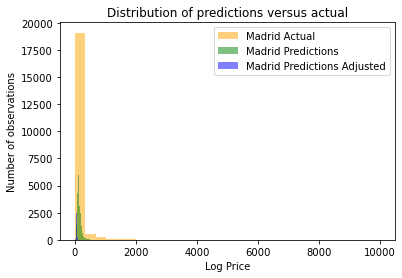

In [82]:
plt.hist(np.exp(y_madrid_test), bins=30, label='Madrid Actual', color='orange', alpha = 0.5)
plt.hist(np.exp(y_knn_ult), bins=30, label='Madrid Predictions', color='green',alpha = 0.5)
plt.hist(np.exp(y_adjusted), bins=30, label='Madrid Predictions Adjusted', color='blue',alpha = 0.5)
# plt.hist(y, bins=30, label='Training Data USA', color='blue', alpha = 0.5)
plt.title('Distribution of predictions versus actual')
plt.ylabel('Number of observations')
plt.xlabel('Log Price')
plt.legend()
plt.show()

In [93]:
eur_col = (y_paris_test.shape[0]*paris_col + y_madrid_test.shape[0]*madrid_col + 
 y_london_test.shape[0]*london_col)/(y_paris_test.shape[0] + y_madrid_test.shape[0] + y_london_test.shape[0])

In [100]:
knn_ult = KNeighborsRegressor(n_neighbors=7)

#start timer
time0 = time.time()


# Fit a nearest neighbor classifier on the embedded training set
knn_ult.fit(pca_15.transform(X), y)
#time for training
time1 = time.time()

# Compute the nearest neighbor accuracy on the embedded test set
y_knn_ult = knn_ult.predict(pca_15.transform(X_eur))
y_adjusted = np.log(np.exp(y_knn_ult / eur_col))
r2 = r2_score(y_eur, y_adjusted)

#time for test
time2 = time.time()

rmse_ult = mean_squared_error(np.exp(y_eur), np.exp(y_adjusted), squared=False)
mae_ult = mean_absolute_error(np.exp(y_eur), np.exp(y_adjusted))
medae_ult = median_absolute_error(np.exp(y_eur), np.exp(y_adjusted))

print('Result for Europe')
print("KNN(PCA_15) (k=7)\nTest score = {:.2f}".format(r2))
print('RMSE (on normal price):',rmse_ult)
print('Mean Absolute Error:', mae_ult)
print('Median Absolute Error:', medae_ult)
print('KNN (PCA_15) (k=7) Europe prediction time ={:.2f}\n'.format(time2-time1))

Result for Europe
KNN(PCA_15) (k=7)
Test score = 0.24
RMSE (on normal price): 300.74600768832147
Mean Absolute Error: 61.000456468750286
Median Absolute Error: 24.11051375848767
KNN (PCA_15) (k=7) Europe prediction time =138.82

